# John Wu
# CSE 5524
# 10/28/22
### Libraries

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
import operator as op
import itertools as it
from PIL import Image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import morphology
# plt.rcParams['figure.figsize'] = [20, 20]

### 1) Load the 100 pairs of corresponding 2-D and 3-D points in the files 2Dpoints.txt and 3Dpoints.txt (the ith row of both files corresponds to the ith point). Use these point correspondences to solve (using Eigen-analysis) for the camera matrix P (whose rasterized vector p has a unit L 2 norm). [5 pts]

In [29]:
points2D = np.loadtxt('2Dpoints.txt')
points3D = np.loadtxt('3Dpoints.txt')
print(points2D.shape)
print(points3D.shape)

(100, 2)
(100, 3)


In [30]:
def xRow(point2d, point3d):
    # first 4 term
    row = np.zeros(12)
    for i in range(3):
        row[i] = point3d[i]
    row[3] = 1
    # last 4 terms
    for i in range(8,row.shape[0] - 1):
        row[i] = -point3d[i - 8] * point2d[0]
    row[11] = -point2d[0]
    return row
    
def yRow(point2d, point3d):
     # 2nd 4 term
    row = np.zeros(12)
    for i in range(4,7):
        row[i] = point3d[i - 4]
    row[7] = 1
    # last 4 terms
    for i in range(8, row.shape[0] - 1):
        row[i] = - point3d[i - 8] * point2d[1]
    row[11] = -point2d[1]
    return row
    
def matrixA(points2D, points3D):
    A = np.zeros((2*points2D.shape[0], 12)) # A matrix with all the necessary parameters
    i = 0
    j = 0
    while i < A.shape[0]:
        A[i] = xRow(points2D[j,:], points3D[j,:])
        A[i+1]= yRow(points2D[j,:], points3D[j,:])
        j+=1
        i+=2
    return A
        

In [31]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def solveP(points2D, points3D):
    A = matrixA(points2D, points3D) # A matrix with all the necessary parameters
    eigVals, eigVec = np.linalg.eig(np.matmul(np.transpose(A), A))
    minEigVal = np.argmin(eigVals)
    minEigVec = np.real(eigVec[:,minEigVal])
    minEigVec = normalized(minEigVec)
    return minEigVec.reshape(3,4)


In [32]:
P = solveP(points2D, points3D)
np.savetxt('p1_p.txt',P)
print(P)


[[ 2.12334889e-03  2.03515474e-03  1.66866146e-03 -9.12330958e-01]
 [-6.18914672e-04  1.38208139e-04  2.75872598e-03 -4.09429271e-01]
 [ 4.24766779e-06 -2.12817126e-06  3.68288121e-06 -6.69669251e-04]]


#### p:
    2.123348892023897618e-03 2.035154742075957063e-03 1.668661464237990600e-03 -9.123309575941531691e-01
    -6.189146719843439601e-04 1.382081393968451026e-04 2.758725976879107620e-03 -4.094292706927471492e-01
    4.247667790058750471e-06 -2.128171259131838817e-06 3.682881210460582797e-06 -6.696692505603117716e-04



### 2) Given the computed matrix P (from Problem 1), project the 3-D homogeneous points (X i ,Y i ,Zi ,1) to 2-D. Compute the sum-of-squared error (sum-of-squared Euclidean distances) between the resulting 3-D-to-2-D projected points and the given 2-D points (ensure all 2-D points are inhomogeneous). [3 pts]

In [33]:
def inhomogenize(x):
    h = np.zeros((x.shape[0], x.shape[1] -1))
    for j in range(x.shape[1] - 1):
        h[:,j] = np.divide(x[:,j], x[:,x.shape[1] - 1]).reshape(x.shape[0])
    return h
def sse(x,y):
    return np.sum(np.square(x-y))

In [34]:
points3DHomogenous = np.concatenate([points3D, np.ones((points3D.shape[0],1))], axis=1) # get homogenous
projected3Dto2d = np.transpose(np.matmul(P, np.transpose(points3DHomogenous))) # flip it back to the same original dimension
inhomogenous2D = inhomogenize(projected3Dto2d)
print("SSE:",sse(inhomogenous2D,points2D))

SSE: 18.744283194638644


##### SSE of 3D-to-2D Points: 18.744, which is pretty low error for sum of squared errors across 100 points with massive values.

### 3) The file homography.txt contains 15 corresponding 2-D points from two different images, where the first and second columns correspond to the x and y coordinates of the points in the first image and the third and fourth columns correspond to the x and y coordinates of the points in the second image. Load the 2-D point sets and use the Normalized Direct Linear Transformation algorithm to compute the final homography H that maps the original points from image 1 to image 2 (i.e., make sure P 2 = HP 1 ). [5 pts]

In [35]:
def xHRow(p1, p2):
    # first 3 term
    row = np.zeros(9)
    for i in range(2):
        row[i] = p1[0,i]
    row[2] = 1
    # last 3 terms
    for i in range(6,row.shape[0] - 1):
        row[i] = -p1[0,i - 6] * p2[0,0]
    row[8] = -p2[0,0]
    return row
    
def yHRow(p1, p2):

     # 2nd 3 term
    row = np.zeros(9)
    for i in range(3,5):
        row[i] = p1[0,i - 3]
    row[5] = 1
    # last 3 terms
    for i in range(6, row.shape[0] - 1):
        row[i] = -p1[0,i - 6] * p2[0,1]
    row[8] = -p2[0,1]
    return row
    
def matrixAH(p1, p2):
    A = np.zeros((2*p1.shape[0], 9)) # A matrix with all the necessary parameters
    i = 0
    j = 0
    while i < A.shape[0]:
        A[i,:] = xHRow(p1[j,:], p2[j,:])
        A[i+1,:]= yHRow(p1[j,:], p2[j,:])
        j+=1
        i+=2
    return A
        
def normalizeT(p):
    mean = np.mean(p, axis=0)
    s = np.square(p-mean)
    s = s[:,0] + s[:,1]
    s = np.sqrt(s)
    s = np.sum(s)
    s = s / p.shape[0]
    s = np.sqrt(2) / s
    return np.matrix([[s, 0, -s*mean[0]],[0,s,-s*mean[1]],[0,0,1]]) 
        

def solveH(points1, points2):
    tA = normalizeT(points1)
    tB = normalizeT(points2)
    tP1 = np.concatenate([points1, np.ones((points1.shape[0],1))], axis=1)
    tP2 = np.concatenate([points2, np.ones((points1.shape[0],1))], axis=1)
    tP1 = np.transpose(np.matmul(tA, np.transpose(tP1)))
    tP2 = np.transpose(np.matmul(tB, np.transpose(tP2))) 
    A = matrixAH(tP1, tP2) # A matrix with all the necessary parameters
    eigVals, eigVec = np.linalg.eig(np.matmul(np.transpose(A), A))
    minEigVal = np.argmin(eigVals)
    minEigVec = np.real(eigVec[:,minEigVal])
    # now get original homography transformation
    return np.linalg.inv(tB) @ (minEigVec.reshape(3,3) @ tA)

In [36]:
homographyData = np.loadtxt('homography.txt', delimiter=',')
print(homographyData.shape)

(15, 4)


In [37]:
points1 = homographyData[:,0:2]
points2 = homographyData[:,2:4]
H = solveH(points1, points2)
print(H)
np.savetxt('p2_H.txt', H)

[[ 3.87480204e-01  4.84207998e-01 -2.13950934e+01]
 [-6.08850486e-02  2.70882946e-01  9.04191215e+01]
 [ 2.64281729e-04  3.34607182e-04  4.07209735e-01]]


##### H:
    [[ 3.87480204e-01  4.84207998e-01 -2.13950934e+01]
    [-6.08850486e-02  2.70882946e-01  9.04191215e+01]
    [ 2.64281729e-04  3.34607182e-04  4.07209735e-01]]

### 4) Plot the points from image 2 and the projected points from image 1 on the same plot. Make sure the projected points are converted into inhomogeneous form. [1 pt]

In [38]:
points1Homogenous = np.concatenate([points1, np.ones((points1.shape[0],1))], axis=1) # get homogenous
projected1to2 = np.transpose(np.matmul(H, np.transpose(points1Homogenous))) # flip it back to the same original dimension
inhomogenous1to2 = inhomogenize(projected1to2)

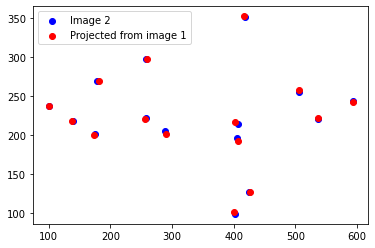

In [39]:
a = plt.scatter(points2[:,0], points2[:,1], color='b', label='Image 2')
b = plt.scatter(inhomogenous1to2[:,0], inhomogenous1to2[:,1], color='r', label= 'Projected from image 1')
plt.legend()
plt.savefig('p2_plot.png')

### 5) Compute the sum-of-squared error (sum-of-squared Euclidean distances) between the actual points from image 2 and the projected points from image 1. [2 pts]

In [40]:
print("SSE:",sse(inhomogenous1to2, points2))

SSE: 105.97387926939282


##### Discussion for both methods (P and H):

##### Regarding the P method, the error was fairly small in terms of the projected 2D points and the ground truth 2D points of 18.7. We can consider this error to be fairly small given that most of the coordinates in 3D were in the thousands and the 2D points in the hundreds. As a reminder, the sqrt(25) = 5, so for context, we have an even smaller error in terms of distance between the projection and the ground truth. This is pretty good considering how many assumptions we make in the context of this problem. 

##### Regarding the H (normalized direct linear transformation) method, similar to how the P method, we construct another transformation matrix but this time we don't have a 4th column in the transformation matrix H for the extra dimension that we're projecting down from. However, interestingly enough, the SSE is greater at 105, which is pretty substantial despite the plotted projection being very close to the actual image 2 on the plot above. Then again, this may make sense as we make a substantial "poster" assumption on the points/ image we're looking at! 